In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [2]:
np.random.seed(42)
real = pd.DataFrame(np.random.uniform(0.3,0.7,1000), columns=["prob of win"])
crowd = pd.DataFrame(np.random.uniform(0.3,0.7,1000), columns=["crowd odds given"])
df = pd.concat([real,crowd], axis = 1)
df

,prob of win,crowd odds given
0,0.449816,0.374053
1,0.680286,0.516760
2,0.592798,0.649178
3,0.539463,0.592890
4,0.362407,0.622624
...,...,...
995,0.336633,0.562782
996,0.666925,0.682646
997,0.354727,0.327583
998,0.680095,0.322822


The Kelly Criterion is a mathematical formula used to determine the optimal size of a bet when the expected returns are known. The formula takes into account the probability of a favorable return, the ratio of average wins to average losses, and the win to loss ratio. The formula is **k% = bp–q/b**. The Kelly Criterion is used by investors and gamblers to decide how much money they should allocate to each investment or bet through a predetermined fraction of assets. The formula was developed by John Kelly.
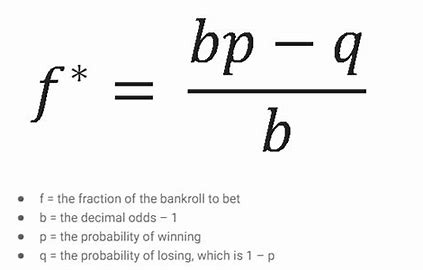

In [3]:
def calculate_odds(data, crowd_col):
    american_odds = []
    riskwins = []

    for prob in data[crowd_col].to_list():
        if prob <= 0.5:
            american_odd = (100 - prob * 100) / prob
            risktowin = american_odd/100
        else:
            american_odd = (prob*100)/(prob-1)
            risktowin = ((american_odd-100)/american_odd)-1
        american_odds.append(american_odd)
        riskwins.append(risktowin)


    moneyline = pd.DataFrame(american_odds, columns=["american odds"])
    ratio = pd.DataFrame(riskwins, columns=["risk-1-to-win"])
    df = pd.concat([data, moneyline, ratio], axis = 1)

    p = df["prob of win"]
    q = 1 - df["prob of win"]
    b = df["risk-1-to-win"]

    #Using a half-kelly to reduce risk
    df['kelly criterion'] = ((b*p-q)/b)*.5

    return df

df = calculate_odds(df, "crowd odds given")

In [4]:
df.head()

,prob of win,crowd odds given,american odds,risk-1-to-win,kelly criterion
0,0.449816,0.374053,167.341671,1.673417,0.060519
1,0.680286,0.516760,-106.936674,0.935133,0.169197
2,0.592798,0.649178,-185.045109,0.540409,-0.080355
3,0.539463,0.592890,-145.633831,0.686654,-0.065617
4,0.362407,0.622624,-164.988027,0.606105,-0.344772


In [5]:
# this function creates a coin-flip (1,0) senario given outcome probabilities and appends it to a dataframe
def win_loss(data, col):
    probs = data[col].to_list()
    results = []
    for prob in probs:
    # if a team has a 0.6 chance of winning, this for loop
    # creates one number out of 0 or 1 with prob p 0.4 for 0 and 0.6 for 1
        winloss = np.random.choice(np.arange(0, 2), p=[1-prob, prob])
        results.append(winloss)
    data['win/loss'] = pd.DataFrame(results)

win_loss(df, "prob of win")

In [6]:
df.head()

,prob of win,crowd odds given,american odds,risk-1-to-win,kelly criterion,win/loss
0,0.449816,0.374053,167.341671,1.673417,0.060519,0
1,0.680286,0.516760,-106.936674,0.935133,0.169197,0
2,0.592798,0.649178,-185.045109,0.540409,-0.080355,1
3,0.539463,0.592890,-145.633831,0.686654,-0.065617,0
4,0.362407,0.622624,-164.988027,0.606105,-0.344772,0


In [7]:
df['win/loss'].value_counts()

0    504
1    496
Name: win/loss, dtype: int64

In [8]:
# calculates change in bankroll money over time and appends to dataframe
def calculate_bankroll(data, kelly_col):
    
    # filter dataset to only include positive kelly criterions
    df_bets = data[data[kelly_col] > 0].reset_index(drop=True)
    
    #simulate bankroll overtime
    starting_bankroll = 1000
    new_bankroll = 1000
    rolling_bankroll = []

    for i in np.asarray(df_bets):
        risk_to_win = i[3]
        kelly = i[4]
        winloss = i[5]

        if winloss == 1:
            new_bankroll = new_bankroll + new_bankroll*kelly*risk_to_win
        elif winloss == 0:
            new_bankroll = new_bankroll - new_bankroll*kelly

        rolling_bankroll.append(new_bankroll)
        
    # append new column to new dataframe
    df_bets = pd.concat([df_bets, pd.DataFrame(rolling_bankroll, columns=["rolling bankroll"])], axis = 1)
        
    return df_bets
    
df = calculate_bankroll(df, "kelly criterion")

In [9]:
df.head(10)

,prob of win,crowd odds given,american odds,risk-1-to-win,kelly criterion,win/loss,rolling bankroll
0,0.449816,0.374053,167.341671,1.673417,0.060519,0,939.481380
1,0.680286,0.516760,-106.936674,0.935133,0.169197,0,780.523993
2,0.646470,0.639678,-177.529744,0.563286,0.009425,1,784.667852
3,0.540446,0.399867,150.083025,1.500830,0.117123,0,692.765138
4,0.583229,0.495770,101.706442,1.017064,0.086725,1,753.870670
5,0.384936,0.315771,216.685469,2.166855,0.050542,0,715.768380
6,0.421697,0.372230,168.651003,1.686510,0.039399,0,687.567964
7,0.416492,0.313578,218.899525,2.188995,0.074964,1,800.394399
8,0.614070,0.489686,104.212626,1.042126,0.121871,0,702.849795
9,0.536966,0.427640,133.841445,1.338414,0.095504,0,635.724622


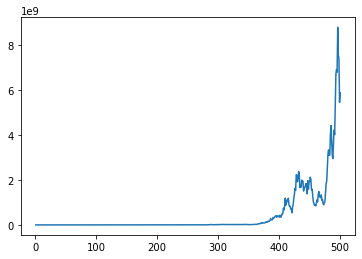

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(df)+1), df["rolling bankroll"])

In [11]:
min(df["rolling bankroll"]), max(df["rolling bankroll"])

(529.8559200420468, 8793794738.065722)

In [12]:
df["win/loss"].value_counts()

1    272
0    228
Name: win/loss, dtype: int64

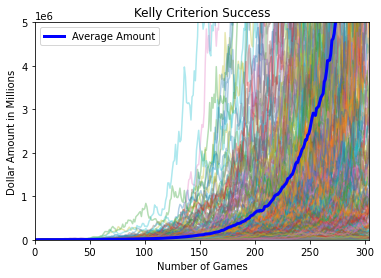

In [13]:
seeds = range(1,501)
number_of_games = 600

fig, ax = plt.subplots()

dictTest = {}
averages = []

min_bankroll = []
max_bankroll = []
mean_bankroll = []
final_acct_value = []

bankrupt_count = 0
success_count = 0
total_count = 0 

for s in seeds:
    
    #set seed
    np.random.seed(s)
    
    #create df
    real = pd.DataFrame(np.random.uniform(0.35,0.65,number_of_games), columns=["prob of win"])
    crowd = pd.DataFrame(np.random.uniform(0.35,0.65,number_of_games), columns=["crowd odds given"])
    df = pd.concat([real,crowd], axis = 1)
    
    #calculate kelly criterion
    df = calculate_odds(df, "crowd odds given")
    
    #simulate win/loss
    win_loss(df, "prob of win")

    #calculate bankroll change over time
    df = calculate_bankroll(df, "kelly criterion")
    
    #save min and max values for further analysis
    min_bankroll.append(int(min(df['rolling bankroll'])))
    max_bankroll.append(int(max(df['rolling bankroll'])))
    mean_bankroll.append(int(df['rolling bankroll'].mean()))
    final_acct_value.append(int(df.iloc[-1]["rolling bankroll"]))
    
    #count the total number of bankrupt and success accounts 
    if min(df["rolling bankroll"]) < 100:
        bankrupt_count += 1
    
    if max(df["rolling bankroll"]) >= 100000:
        success_count += 1
    
    total_count += 1 
    
    test2 = enumerate(df["rolling bankroll"].to_list())

    for i in test2:
    #     print(i[0])
        if i[0] in dictTest:
            dictTest[i[0]].append(int(i[1])) 
        else:
            dictTest[i[0]] = [int(i[1])]
            
    ax.plot(range(1,len(df)+1), df["rolling bankroll"], alpha=.35)
            
for key in dictTest.values():
    averages.append(np.mean(key))
    
ax.plot(range(1,len(df)+1), averages[:len(df)], 'b', alpha=1, lw=3, label="Average Amount")
ax.set_ylim(0,5000000)
ax.set_xlim(0,len(df)+1)
ax.set_ylabel("Dollar Amount in Millions")
ax.set_xlabel("Number of Games")
ax.set_title("Kelly Criterion Success")
ax.legend()
plt.show()

min value: 152


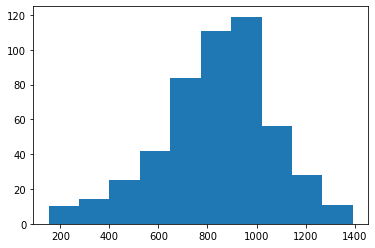

In [14]:
print(f"min value: {round(min(min_bankroll),2)}")
plt.hist(min_bankroll)
plt.show()

In [15]:
print("Half-Kelly")
print(f"min: {min(min_bankroll)}, max: {max(max_bankroll)}, mean: {int(np.mean(mean_bankroll))}")
print(f"Final amts min, max, mean: {min(final_acct_value)}, {max(final_acct_value)}, {int(np.mean(final_acct_value))}")

Half-Kelly
min: 152, max: 1978614182, mean: 1555753
Final amts min, max, mean: 1786, 1022926044, 11862402


In [16]:
len(averages)

343

In [17]:
bankrupt_count, success_count, total_count

(0, 454, 500)

Of 500 randomly created accounts betting on a max of 343 games each, 0 went bankrupt (defined as having less than 100 dollars at any given time), whereas 454 accounts surpassed 100,000 dollars at some point. 

The overall mean value was $1,555,753. 

The average final account value was $11,862,402.

Further analysis on the Kelly Criterion and it's betting applications could be done to assess the impact of casino odds advantages and real world data. 

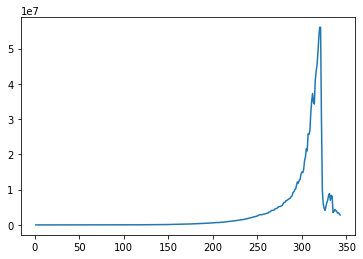

In [18]:
plt.plot(range(1, len(averages)+1), averages)

In [19]:
averages[-10:]

[8103112.333333333,
 3499907.0,
 3787077.0,
 4358255.0,
 4042057.0,
 3916137.0,
 3371775.0,
 3452859.0,
 3163094.0,
 2818237.0]

In [520]:
ml = pd.read_csv("538_ml.csv")
print(ml.shape)
ml.head()

(18412, 17)


,Unnamed: 0,date,season,neutral,playoff,home_team,away_team,home_elo_prob,away_elo_prob,home_carm-elo_prob,away_carm-elo_prob,home_raptor_prob,away_raptor_prob,home_score,away_score,home_ml,away_ml
0,0,2007-10-30,2008,0,NaN,SAS,POR,0.882229,0.117771,NaN,NaN,NaN,NaN,106.0,97.0,-1400,900
1,1,2007-10-30,2008,0,NaN,LAL,HOU,0.536006,0.463994,NaN,NaN,NaN,NaN,93.0,95.0,190,-230
2,2,2007-10-30,2008,0,NaN,GSW,UTA,0.637471,0.362529,NaN,NaN,NaN,NaN,96.0,117.0,-120,100
3,3,2007-10-31,2008,0,NaN,CLE,DAL,0.600327,0.399673,NaN,NaN,NaN,NaN,74.0,92.0,120,-140
4,4,2007-10-31,2008,0,NaN,NOP,SAC,0.713491,0.286509,NaN,NaN,NaN,NaN,104.0,90.0,-525,425


In [521]:
ml.loc[ml['home_score'] > ml["away_score"], 'team_w/l'] = "Home"
ml.loc[ml['home_score'] < ml["away_score"], 'team_w/l'] = "Away"
ml = ml[["date", 
         "season", 
         "playoff", 
         "home_team", 
         "away_team", 
         "home_score", 
         "away_score", 
         "home_ml", 
         "away_ml", 
         "team_w/l"]]
ml.head()

,date,season,playoff,home_team,away_team,home_score,away_score,home_ml,away_ml,team_w/l
0,2007-10-30,2008,NaN,SAS,POR,106.0,97.0,-1400,900,Home
1,2007-10-30,2008,NaN,LAL,HOU,93.0,95.0,190,-230,Away
2,2007-10-30,2008,NaN,GSW,UTA,96.0,117.0,-120,100,Away
3,2007-10-31,2008,NaN,CLE,DAL,74.0,92.0,120,-140,Away
4,2007-10-31,2008,NaN,NOP,SAC,104.0,90.0,-525,425,Home


In [522]:
def convert_odds_home(df, ml_column, home_away):
    implied_probability = []
    
    for odd in df[ml_column].to_list():
        if odd < 0:
            prob = -odd/(-odd+100)
        else:
            prob = 100/(odd+100)
        implied_probability.append(prob)
        
    probs = pd.DataFrame(implied_probability, columns=["implied_prob_"+home_away])
    df = pd.concat([df, probs], axis = 1)

    return df

ml = convert_odds_home(ml, "home_ml", "home")
ml = convert_odds_home(ml, "away_ml", "away")
ml.head()

,date,season,playoff,home_team,away_team,home_score,away_score,home_ml,away_ml,team_w/l,implied_prob_home,implied_prob_away
0,2007-10-30,2008,NaN,SAS,POR,106.0,97.0,-1400,900,Home,0.933333,0.100000
1,2007-10-30,2008,NaN,LAL,HOU,93.0,95.0,190,-230,Away,0.344828,0.696970
2,2007-10-30,2008,NaN,GSW,UTA,96.0,117.0,-120,100,Away,0.545455,0.500000
3,2007-10-31,2008,NaN,CLE,DAL,74.0,92.0,120,-140,Away,0.454545,0.583333
4,2007-10-31,2008,NaN,NOP,SAC,104.0,90.0,-525,425,Home,0.840000,0.190476


The sum of the implied probabilties does not equal one because the odds makers modify the odds to get a cut. For example, if two teams have an equal chance of winning (i.e. 50% or +100 on the moneyline), the odds makers will set the moneyline at -110 for both teams, or sometimes -105 to attract more bets. Once the betting starts, their job is to keep the payout on both sides of the game equal, so that no matter who wins, they take their 5-10% cut. 

For this reason, the implied probabilities need to be adjusted.

In [523]:
ml["home_expected_prob"] = ml["implied_prob_home"] - ((ml["implied_prob_home"] + ml["implied_prob_away"]) - 1) / 2
ml["away_expected_prob"] = ml["implied_prob_away"] - ((ml["implied_prob_home"] + ml["implied_prob_away"]) - 1) / 2
ml.head()

,date,season,playoff,home_team,away_team,home_score,away_score,home_ml,away_ml,team_w/l,implied_prob_home,implied_prob_away,home_expected_prob,away_expected_prob
0,2007-10-30,2008,NaN,SAS,POR,106.0,97.0,-1400,900,Home,0.933333,0.100000,0.916667,0.083333
1,2007-10-30,2008,NaN,LAL,HOU,93.0,95.0,190,-230,Away,0.344828,0.696970,0.323929,0.676071
2,2007-10-30,2008,NaN,GSW,UTA,96.0,117.0,-120,100,Away,0.545455,0.500000,0.522727,0.477273
3,2007-10-31,2008,NaN,CLE,DAL,74.0,92.0,120,-140,Away,0.454545,0.583333,0.435606,0.564394
4,2007-10-31,2008,NaN,NOP,SAC,104.0,90.0,-525,425,Home,0.840000,0.190476,0.824762,0.175238


In [524]:
def bin_probs(df, implied_prob, increment, home_away):

    binned_probs = [] 
    for prob in df[implied_prob].to_list():
        
        prob = prob
        
        if 0 < prob <= 20:
            range_index = (prob - 1) // increment
            prob = (range_index * 2 + 1) * (increment / 2) + 1
            prob = str(abs(round(prob-increment/2,2))) + "-" + str(round(prob+increment/2,2))
        

            binned_probs.append(prob)
        
    probs_binned = pd.DataFrame(binned_probs, columns=["probs_binned_"+home_away])
    df = pd.concat([df, probs_binned], axis = 1)
    
    return df

ml = bin_probs(ml, "home_expected_prob", increment = 0.2, home_away = "home")

In [525]:
ml.head()

,date,season,playoff,home_team,away_team,home_score,away_score,home_ml,away_ml,team_w/l,implied_prob_home,implied_prob_away,home_expected_prob,away_expected_prob,probs_binned_home
0,2007-10-30,2008,NaN,SAS,POR,106.0,97.0,-1400,900,Home,0.933333,0.100000,0.916667,0.083333,0.8-1.0
1,2007-10-30,2008,NaN,LAL,HOU,93.0,95.0,190,-230,Away,0.344828,0.696970,0.323929,0.676071,0.2-0.4
2,2007-10-30,2008,NaN,GSW,UTA,96.0,117.0,-120,100,Away,0.545455,0.500000,0.522727,0.477273,0.4-0.6
3,2007-10-31,2008,NaN,CLE,DAL,74.0,92.0,120,-140,Away,0.454545,0.583333,0.435606,0.564394,0.4-0.6
4,2007-10-31,2008,NaN,NOP,SAC,104.0,90.0,-525,425,Home,0.840000,0.190476,0.824762,0.175238,0.8-1.0


In [526]:
# calculate the mean of the distribution within the binned categories

df_means = ml.groupby(["probs_binned_home", "team_w/l"])["implied_prob_home"].mean().reset_index(name="expected_win_pct")
df_count = ml.groupby(["probs_binned_home", "team_w/l"])["team_w/l"].count().reset_index(name="observed_count")
tot_count = ml.groupby(["probs_binned_home"])["team_w/l"].count().reset_index()
tot_count.rename(columns={"team_w/l": "tot_games"}, inplace=True)
df_means = df_means[df_means["team_w/l"]=="Home"].reset_index(drop=True)
df_count = df_count[df_count["team_w/l"]=="Home"].reset_index(drop=True)

summary_df = pd.concat([tot_count, df_means[["team_w/l", "expected_win_pct"]], df_count[["observed_count"]]], axis=1)
summary_df["expected_count"] = round(summary_df["expected_win_pct"] * summary_df["tot_games"],2)
summary_df["observed_win_pct"] = summary_df["observed_count"] / summary_df["tot_games"]

neworder = ['probs_binned_home', 'team_w/l', 'tot_games', 'observed_count', 
            'expected_count', 'expected_win_pct','observed_win_pct']
summary_df = summary_df.reindex(columns=neworder)

summary_df["pct_off"] = summary_df["observed_win_pct"] - summary_df["expected_win_pct"]

summary_df

,probs_binned_home,team_w/l,tot_games,expected_count,observed_count,expected_win_pct,observed_win_pct,pct_off
0,0.0-0.2,Home,643,110.11,107,0.171242,0.166407,-0.004835
1,0.2-0.4,Home,3155,1078.64,1012,0.341882,0.320761,-0.021121
2,0.4-0.6,Home,5048,2686.42,2511,0.532176,0.497425,-0.034751
3,0.6-0.8,Home,6186,4468.64,4280,0.722380,0.691885,-0.030495
4,0.8-1.0,Home,3380,3024.92,2910,0.894947,0.860947,-0.034000


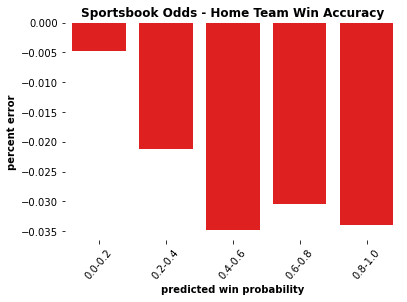

In [527]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

x=summary_df['probs_binned_home']
y=summary_df['pct_off']

colors = ['pink' if _y >=0 else 'red' for _y in y]
ax = sns.barplot(x, y, palette=colors)

ax.set_ylabel("percent error", fontweight='bold')
ax.set_xlabel("predicted win probability", fontweight='bold')
ax.set_title("Sportsbook Odds - Home Team Win Accuracy", fontweight='bold')
ax.tick_params (axis='x', labelrotation=50)

sns.despine(ax=ax, bottom=True, left=True)
plt.show()

A negative percent error means the teams actually did worse than predicted, meaning they won less games than predicted, whereas a positive percent error means they won more games than predicted. Here we can see a slight trend in over/underperformance at the most extreme implied probabilities.

Notice that it is slightly imbalanced. This is due to the home team advantage phenomenon. 

In [528]:
import scipy.stats as stats

def calc_chisquare(data, observed_col, expected_col, total_count_col):

    # Define the observed and expected counts
    observed_wins = data[observed_col]
    total_observations = data[total_count_col]
    expected_wins = data[expected_col]

    # Calculate the expected losses (assuming a binary outcome of wins and losses)
    expected_losses = total_observations - expected_wins

    # Create an observed frequency array
    observed_counts = [observed_wins, total_observations - observed_wins]

    # Create an expected frequency array
    expected_counts = [expected_wins, expected_losses]

    # Perform the chi-squared goodness-of-fit test
    data["chi2"], data["p_value"] = stats.chisquare(observed_counts, f_exp=expected_counts)

    # 'chi2' is the chi-squared statistic
    # 'p_value' is the p-value
    
    # interpret the results
    data['5% significant?'] = data.apply(lambda row: 'Yes(bad)' if abs(row['p_value']) <= 0.05 else 'No(good)', axis=1)
    
    return data

result_df = calc_chisquare(summary_df, "observed_count", "expected_count", "tot_games") 

result_df

,probs_binned_home,team_w/l,tot_games,expected_count,observed_count,expected_win_pct,observed_win_pct,pct_off,chi2,p_value,5% significant?
0,0.0-0.2,Home,643,110.11,107,0.171242,0.166407,-0.004835,0.105991,7.447558e-01,No(good)
1,0.2-0.4,Home,3155,1078.64,1012,0.341882,0.320761,-0.021121,6.255905,1.237800e-02,Yes(bad)
2,0.4-0.6,Home,5048,2686.42,2511,0.532176,0.497425,-0.034751,24.485049,7.488869e-07,Yes(bad)
3,0.6-0.8,Home,6186,4468.64,4280,0.722380,0.691885,-0.030495,28.684070,8.520171e-08,Yes(bad)
4,0.8-1.0,Home,3380,3024.92,2910,0.894947,0.860947,-0.034000,41.559262,1.143514e-10,Yes(bad)


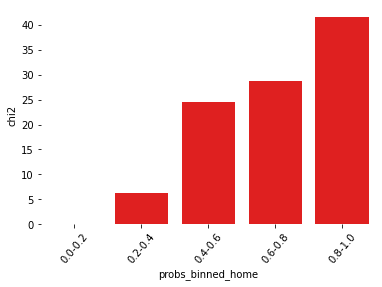

In [531]:
x=result_df['probs_binned_home']
y1=result_df['chi2']
y2=result_df['p_value']

ax = sns.barplot(x, y1, color = 'r')

ax.tick_params (axis='x', labelrotation=50)
sns.despine(ax=ax, bottom=True, left=True)
plt.show()

### Let's interpret these results with an example:

**Chi-squared statistic (chi²) = 0.01286, p-value = 0.9097**

**Chi-squared Statistic (chi²):** The chi-squared statistic measures how much the observed counts differ from the expected counts. In this case, the chi-squared statistic is very close to zero (0.01286). A smaller chi-squared value suggests that the observed and expected counts are very similar and that there is little deviation. In our case, **the smaller the chi2 value, the better.**

**p-value:** The p-value is 0.9097. This is the probability of observing a chi-squared statistic as extreme as the one calculated (or even more extreme) under the null hypothesis that there is no significant difference between the observed and expected counts. Typically, a p-value less than 0.05 is needed to reject the null hypothesis (there is no difference between the two groups). Our p-value in this case is way above 0.05, so we can accept the null hypothesis (which is what we want in this case).

In [304]:
result_df.head()

,probs_binned_home,team_w/l,observed_count,proportion,total_count,expected_count,pct_off,chi2,p_value,10% significant?
0,0.0625,Home,2.0,0.095238,2,0.0750,0.962500,51.333333,7.794091e-13,Yes(bad)
1,0.0875,Home,4.0,0.133333,21,1.3125,0.127976,5.869841,1.540244e-02,Yes(bad)
2,0.1125,Home,5.0,0.087719,30,2.6250,0.079167,2.354860,1.248931e-01,No(good)
3,0.1375,Home,14.0,0.164706,57,6.4125,0.133114,10.115833,1.470009e-03,Yes(bad)
4,0.1625,Home,26.0,0.247619,85,11.6875,0.168382,20.321243,6.546966e-06,Yes(bad)
